In [1]:
!pip install skforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skforecast.model_selection import backtesting_forecaster
import numpy as np
from skforecast.model_selection import grid_search_forecaster
import warnings
warnings.filterwarnings("ignore")

In [18]:
df = pd.read_csv("/content/XAU_15m_data_2004_to_2024-20-09.csv")
df.head()

,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:15,384.0,384.3,383.8,384.3,12
1,2004.06.11,07:30,383.8,384.3,383.6,383.8,12
2,2004.06.11,07:45,383.3,383.8,383.3,383.8,20
3,2004.06.11,08:00,383.8,384.1,383.6,383.6,8
4,2004.06.11,08:15,383.6,384.3,383.5,383.5,20


In [20]:
import pandas as pd

# Ensure the date column is properly converted to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d', errors='coerce')

# Drop any rows where 'Date' conversion failed (optional, depending on your data)
df.dropna(subset=['Date'], inplace=True)

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Drop the 'Time' column if it exists
if 'Time' in df.columns:
    df.drop('Time', inplace=True, axis=1)

# Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Remove any duplicate index entries
df = df[~df.index.duplicated(keep='first')]

# Set the dataset frequency to daily and backfill missing dates
df = df.asfreq('D', method='bfill')

# Forward-fill any remaining missing values
df.ffill(inplace=True)

# Display the final DataFrame
print(df.head())



             Open   High    Low  Close  Volume
Date                                          
2004-06-11  384.0  384.3  383.8  384.3      12
2004-06-12  384.3  384.5  384.3  384.3       4
2004-06-13  384.3  384.5  384.3  384.3       4
2004-06-14  384.3  384.5  384.3  384.3       4
2004-06-15  382.8  383.3  382.6  383.3       3


In [21]:
df['var_Prev_Open'] = df['Open'].shift(1)-df['Open'].shift(2)
df['var_Prev_Close'] = df['Close'].shift(1)-df['Close'].shift(2)
df['var_Prev_High'] = df['High'].shift(1)-df['High'].shift(2)
df['var_Prev_Low'] = df['Low'].shift(1)-df['Low'].shift(2)
df['var_Prev_Volume'] = df['Volume'].shift(1)-df['Volume'].shift(2)
df['var_Close'] = df['Close']-df['Close'].shift(1)
df['prev_Close'] = df['Close'].shift(1)
# Create lagged variables for the 'var_Close' column
for lag in range(1, 31):  # Creating 30 lagged variables
    df[f'var_Prev_Close_lag_{lag}'] = df['var_Prev_Close'].shift(lag)
    df[f'var_Prev_Volume_{lag}'] = df['var_Prev_Volume'].shift(lag)
    df[f'var_Prev_High_{lag}'] = df['var_Prev_High'].shift(lag)
    df[f'var_Prev_Low_{lag}'] = df['var_Prev_Low'].shift(lag)
    df[f'var_Prev_Open_{lag}'] = df['var_Prev_Open'].shift(lag)




# Drop the first row as it will have NaN values for the new columns
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,var_Prev_Open,var_Prev_Close,var_Prev_High,var_Prev_Low,var_Prev_Volume,...,var_Prev_Close_lag_29,var_Prev_Volume_29,var_Prev_High_29,var_Prev_Low_29,var_Prev_Open_29,var_Prev_Close_lag_30,var_Prev_Volume_30,var_Prev_High_30,var_Prev_Low_30,var_Prev_Open_30
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-13,407.1,407.1,407.1,407.1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-8.0,0.2,0.5,0.3
2004-07-14,400.8,400.8,400.8,400.8,2,-0.2,-0.2,-0.2,-0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-07-15,404.3,404.3,404.1,404.3,6,-6.3,-6.3,-6.3,-6.3,1.0,...,-1.0,-1.0,-1.2,-1.7,-1.5,0.0,0.0,0.0,0.0,0.0
2004-07-16,403.1,403.1,403.0,403.1,3,3.5,3.5,3.5,3.3,4.0,...,4.0,-1.0,4.0,4.5,4.3,-1.0,-1.0,-1.2,-1.7,-1.5
2004-07-17,405.5,405.5,405.5,405.5,1,-1.2,-1.2,-1.2,-1.1,-3.0,...,-3.5,2.0,-3.5,-3.5,-3.5,4.0,-1.0,4.0,4.5,4.3


In [22]:
train_start = '2023-01-01'
train_end = '2024-08-31'

test_start = '2024-09-01'
test_end = '2024-09-19'

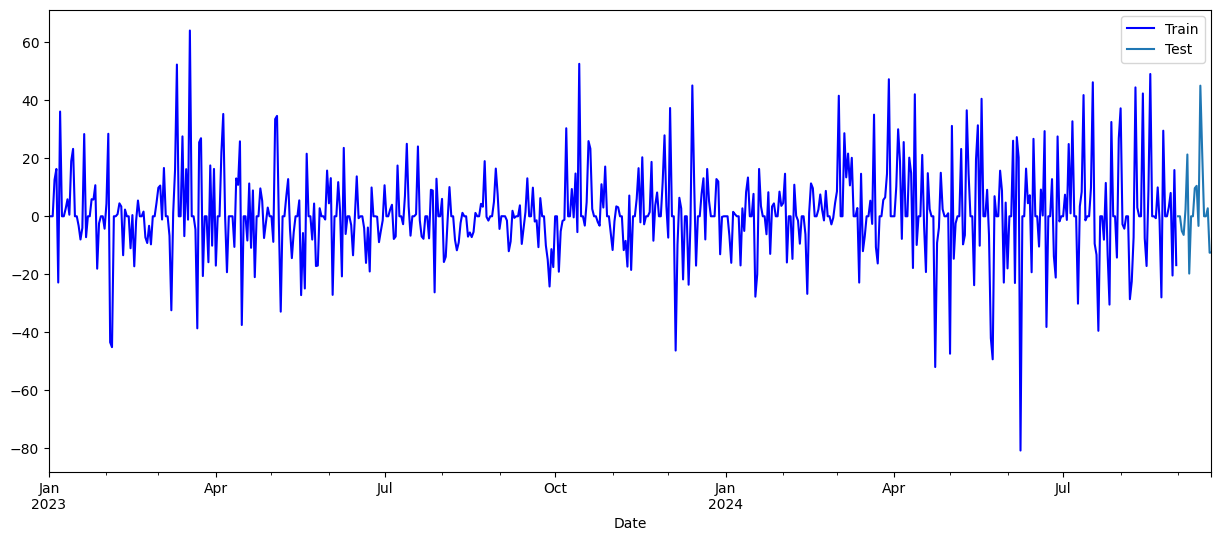

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
df.loc[train_start:train_end, 'var_Close'].plot(ax=ax, label="Train", color='blue')
df.loc[test_start:test_end, 'var_Close'].plot(ax=ax, label="Test")
ax.legend()

In [24]:
# Define the forecaster with multiple series
forecaster = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 30,
)

# Parameter Grid for Regressor
param_grid = {
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    'max_depth' : [None, 1, 3, 5],
    # min_samples_split: The minimum number of samples required to split an internal node.
    'min_samples_split' : [2, 3, 4, 5, 6, 10],
    # ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
    'ccp_alpha' : [0.0, 0.001, 0.01]
}

# lags_grid: The number of previous observations to consider
lags_grid = [30, 50, 100, 150, [1,2,3,4,5,7,9,13,15,20,50], 10, 20]

# Grid Search with Refit and Increasing Train Size
grid_forecaster = grid_search_forecaster(
    # forecaster - our model
    forecaster = forecaster,
    # y - target variable
    y = df.loc[train_start:test_end, 'var_Close'],
    # exog - exogenous variables
    exog = df.loc[train_start:test_end, df.columns.str.contains('var_Prev')],
    # param_grid - dictionary with parameters to test
    param_grid = param_grid,
    # lag_grid - list with lags to test
    lags_grid = lags_grid,
    # steps - number of steps to forecast
    steps = len(df.loc[test_start:test_end]),
    # refit - refit the best model with all data
    refit = True,
    # metric - metric to optimize
    metric = 'mean_squared_error',
    # initial_train_size - initial size of the train data
    initial_train_size = len(df.loc[train_start:train_end]),
    # fixed_train_size - if True, the training size is fixed
    fixed_train_size = False,
    # return_best - return the best model
    return_best = True,
    # verbose - show all messages
    verbose = False
)

# Backtest RMSE
np.sqrt(grid_forecaster.iloc[0]['mean_squared_error'])

Number of models compared: 504.


lags grid:   0%|          | 0/7 [00:00<?, ?it/s]

params grid:   0%|          | 0/72 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'ccp_alpha': 0.001, 'max_depth': None, 'min_samples_split': 2}
  Backtesting metric: 174.27489113318686



13.201321567675974

In [25]:
# Fit the model using train data with multiple series
forecaster.fit(y = df.loc[train_start:train_end, 'var_Close'], exog = df.loc[train_start:train_end, df.columns.str.contains('var_Prev')])

In [27]:
 #Predict the test period with multiple series
predicted_test = forecaster.predict(steps = len(df.loc[test_start:test_end]), exog = df.loc[test_start:test_end, df.columns.str.contains('var_Prev')])

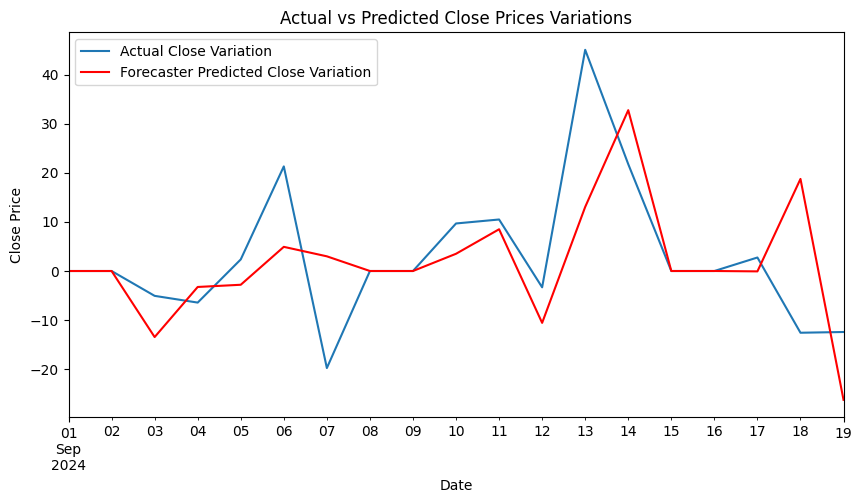

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[test_start:test_end, 'var_Close'].plot(ax=ax, label = "Actual Close Variation")
predicted_test.plot(ax=ax, label='Forecaster Predicted Close Variation', color = 'red')
ax.set_title('Actual vs Predicted Close Prices Variations')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()

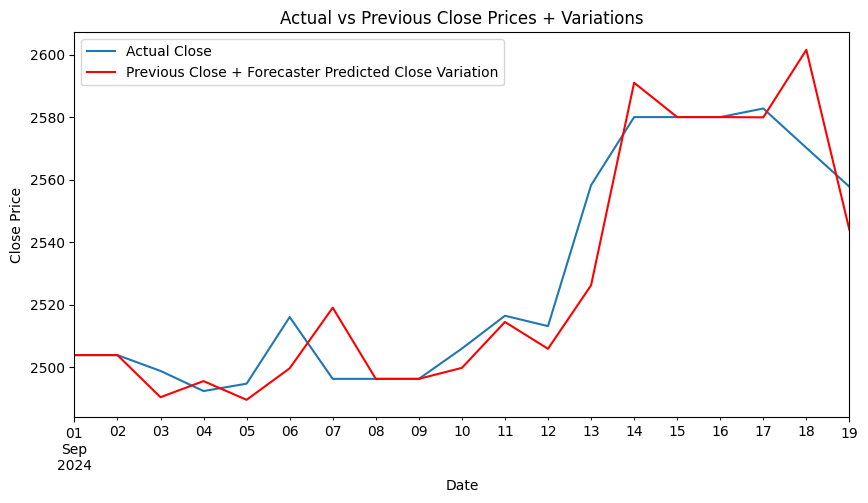

In [29]:
# Plot Close Versus Previous Close + Variation
fig, ax = plt.subplots(figsize=(10, 5))
pred_close = df.loc[test_start:test_end, 'prev_Close'] + predicted_test
df.loc[test_start:test_end, 'Close'].plot(ax=ax, label = "Actual Close")
pred_close.plot(ax=ax, label='Previous Close + Forecaster Predicted Close Variation', color = 'red')
ax.set_title('Actual vs Previous Close Prices + Variations')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()